# 🔧 环境配置和检查

## 概述
本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：
- 使用统一的conda环境
- 通过国内镜像源快速安装依赖
- 加速模型下载
- 检查系统配置

## 配置步骤
1. **Conda环境管理** - 激活统一的学习环境
2. **包管理器优化** - 配置pip使用清华镜像源
3. **模型下载加速** - 设置HuggingFace镜像代理
4. **系统环境诊断** - 检查硬件和软件配置


In [ ]:
# 1. 激活conda环境
%%script bash
# 初始化 conda
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action
conda env list


In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-3/edit-state-human-feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 图状态编辑与人工反馈


## 本教程简介

本教程将向您展示如何在LangGraph中编辑图状态并集成人工反馈。这是构建人机协作AI系统的关键技术，让人类可以在AI执行过程中进行干预和指导。

# 编辑图状态

## 回顾

我们之前讨论了人机协作（human-in-the-loop）的动机：

**(1) 审批（Approval）** - 我们可以中断智能体，向用户展示状态，并允许用户接受某个操作

**(2) 调试（Debugging）** - 我们可以回滚图来重现或避免问题

**(3) 编辑（Editing）** - 您可以修改状态

我们展示了断点如何支持用户审批，但还不知道如何在图被中断后修改图状态！

## 学习目标

现在，让我们展示如何直接编辑图状态并插入人工反馈。

In [1]:
# 安装必要的依赖包
# 这些包是构建LangGraph应用的核心组件
%%capture --no-stderr
# %pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt
%pip install --quiet langgraph==0.6.7 langchain_openai==0.3.32 langgraph_sdk==0.2.6 langgraph-prebuilt==0.6.4

In [2]:
# 设置环境变量
import os, getpass

def _set_env(var: str):
    """安全地设置环境变量，如果不存在则提示用户输入"""
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置OpenAI API密钥，这是使用OpenAI模型所必需的
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


## 编辑状态

之前，我们介绍了断点（breakpoints）。

我们使用断点来中断图，并在执行下一个节点之前等待用户审批。

但断点也是[修改图状态的机会](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/edit-graph-state/)。

让我们在`assistant`节点之前设置一个断点来构建我们的智能体。

In [4]:
# 导入必要的库
from langchain_openai import ChatOpenAI

# 定义数学运算工具函数
def multiply(a: int, b: int) -> int:
    """乘法运算：计算两个整数的乘积

    Args:
        a: 第一个整数
        b: 第二个整数
    """
    return a * b

def add(a: int, b: int) -> int:
    """加法运算：计算两个整数的和

    Args:
        a: 第一个整数
        b: 第二个整数
    """
    return a + b

def divide(a: int, b: int) -> float:
    """除法运算：计算两个整数的商

    Args:
        a: 被除数
        b: 除数
    """
    return a / b

# 将工具函数组合成工具列表
tools = [add, multiply, divide]

# 初始化OpenAI聊天模型
llm = ChatOpenAI(model="gpt-4o")

# 将工具绑定到语言模型，使模型能够调用这些工具
llm_with_tools = llm.bind_tools(tools)

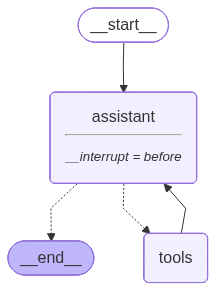

In [5]:
# 导入必要的库
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# 定义系统消息，指导AI助手的行为
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# 定义助手节点函数
def assistant(state: MessagesState):
    """助手节点：使用语言模型处理消息并可能调用工具

    Args:
        state: 包含消息列表的图状态

    Returns:
        包含AI响应的新状态更新
    """
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# 创建状态图构建器
builder = StateGraph(MessagesState)

# 定义节点：这些节点执行具体的工作
builder.add_node("assistant", assistant)  # AI助手节点
builder.add_node("tools", ToolNode(tools))  # 工具执行节点

# 定义边：这些边决定控制流程
builder.add_edge(START, "assistant")  # 从开始到助手
builder.add_conditional_edges(
    "assistant",
    # 如果助手的最新消息是工具调用 -> tools_condition 路由到工具节点
    # 如果助手的最新消息不是工具调用 -> tools_condition 路由到结束
    tools_condition,
)
builder.add_edge("tools", "assistant")  # 从工具回到助手

# 创建内存检查点保存器，用于保存图状态
memory = MemorySaver()

# 编译图，在assistant节点之前设置中断点
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# 显示图的可视化结构
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

让我们运行图！

我们可以看到图在聊天模型响应之前被中断了。

In [6]:
# 定义初始输入：用户要求进行数学运算
initial_input = {"messages": "Multiply 2 and 3"}

# 创建线程配置，用于跟踪对话状态
thread = {"configurable": {"thread_id": "1"}}

# 运行图直到第一个中断点
# 由于设置了interrupt_before=["assistant"]，图会在assistant节点执行前停止
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [7]:
# 获取当前图状态，查看中断时的状态信息
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='47164047-b316-461d-a6db-b688fe22b9e2')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08fb04-cc7f-6ab3-8000-bd10cf2ba52e'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-12T08:13:01.367558+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08fb04-cc7d-67ae-bfff-212de85ada55'}}, tasks=(PregelTask(id='4751155e-2a98-83df-df8a-f489f43e45d3', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

现在，我们可以直接应用状态更新。

记住，对`messages`键的更新将使用`add_messages`归约器：

* 如果我们想要覆盖现有消息，可以提供消息的`id`。
* 如果我们只是想要追加到消息列表中，那么可以传递一个没有指定`id`的消息，如下所示。

In [8]:
# 更新图状态：添加新的人类消息
# 这里我们添加一条新消息来修改用户的原始请求
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08fb05-0434-60e6-8001-c9837f4ce146'}}

让我们看一下结果。

我们使用新消息调用了`update_state`。

`add_messages`归约器将其追加到我们的状态键`messages`中。

In [9]:
# 获取更新后的状态并显示所有消息
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


现在，让我们继续执行我们的智能体，只需传递`None`并允许它从当前状态继续。

我们发出当前状态，然后继续执行剩余的节点。

In [10]:
# 继续执行图，从当前中断点开始
# 传递None表示从当前状态继续，而不是重新开始
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_uAdcIWOIU6ToL8jpdhIwy9NE)
 Call ID: call_uAdcIWOIU6ToL8jpdhIwy9NE
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


现在，我们又回到了`assistant`节点，它设置了我们的`breakpoint`。

我们可以再次传递`None`来继续执行。

In [11]:
# 继续执行图，完成剩余的计算
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The product of 3 and 3 is 9.


### 在Studio中编辑图状态

**⚠️ 免责声明**

自这些视频拍摄以来，我们已经更新了Studio，使其可以在本地运行并在浏览器中打开。这是现在运行Studio的首选方式（而不是使用视频中显示的桌面应用程序）。请参阅[本地开发服务器](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server)的文档和[运行开发服务器](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server)的文档。要启动本地开发服务器，请在此模块的`/studio`目录中的终端运行以下命令：

```
langgraph dev
```

您应该看到以下输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

打开您的浏览器并导航到Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

LangGraph API [支持编辑图状态](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_edit_state/#initial-invocation)。

In [ ]:
# 检查是否在Google Colab环境中运行
# LangGraph Studio目前不支持在Google Colab中运行
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [ ]:
# 这是本地开发服务器的URL
# 创建LangGraph SDK客户端，用于与本地Studio服务器通信
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

我们的智能体定义在`studio/agent.py`中。

如果您查看代码，您会发现它*没有*断点！

当然，我们可以将其添加到`agent.py`中，但API的一个非常好的功能是我们可以传入断点！

在这里，我们传递`interrupt_before=["assistant"]`。

In [ ]:
# 使用LangGraph SDK创建线程并运行智能体
initial_input = {"messages": "Multiply 2 and 3"}
thread = await client.threads.create()

# 异步流式运行智能体，在assistant节点前中断
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],  # 在assistant节点前设置中断点
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46', 'example': False}
--------------------------------------------------


我们可以获取当前状态

In [ ]:
# 获取当前线程的状态信息
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'a71c0b80-a679-57cb-aa59-a1655b763480',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 0,
  'run_id': '1ef6a41c-ea63-663f-b3e8-4f001bf0bf53',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': 'a95ffa54-2435-4a47-a9da-e886369ca8ee',
  'created_by': 'system',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
 'created_at': '2024-09-03T22:13:54.466695+00:00',
 'checkpoint_id': '1ef6a41c-ead7-637b-8000-8c6a7b98379e',
 'parent_checkpoint_id': '1ef6a41c-ead3-637d-bfff-397ebdb4f2ea'}

我们可以查看状态中的最后一条消息。

In [ ]:
# 获取状态中的最后一条消息
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 2 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
 'example': False}

我们可以编辑它！

In [ ]:
# 修改最后一条消息的内容
last_message['content'] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
 'example': False}

In [ ]:
# 显示修改后的消息
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46',
 'example': False}

记住，正如我们之前所说，对`messages`键的更新将使用相同的`add_messages`归约器。

如果我们想要覆盖现有消息，那么我们可以提供消息的`id`。

在这里，我们就是这样做的。我们只修改了消息的`content`，如上所示。

In [ ]:
# 使用修改后的消息更新线程状态
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'configurable': {'thread_id': 'a95ffa54-2435-4a47-a9da-e886369ca8ee',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a41d-cc8e-6979-8001-8c7c283b636c'},
 'checkpoint_id': '1ef6a41d-cc8e-6979-8001-8c7c283b636c'}

现在，我们通过传递`None`来恢复执行。

In [ ]:
# 恢复执行：从当前中断点继续运行智能体
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,  # 传递None表示从当前状态继续
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {'additional_kwargs': {}, 'response_metadata': {}, 'example': False}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '882dabe4-b877-4d71-bd09-c34cb97c4f46', 'example': False}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-775b42f7-0590-4c54-aaeb-78599b1f12d2', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'type

我们得到了工具调用的结果`9`，正如预期的那样。

In [ ]:
# 继续执行，完成最终响应
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '226bfbad-0cea-4900-80c5-761a62bd4bc1', 'tool_call_id': 'call_vi16je2EIikHuT7Aue2sd1qd', 'artifact': None, 'status': 'success'}
--------------------------------------------------
Receiving new event of type: values...
{'content': 'The result of multiplying 3 by 3 is 9.', 'additional_kwargs': {}, 'response_metadata': {'finish_reason': 'stop', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-859bbf47-9f35-4e71-ae98-9d93ee49d16c', 'example': False, 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------------------------------------


## 等待用户输入

所以，很明显我们可以在断点后编辑智能体状态。

现在，如果我们想要允许人工反馈来执行这种状态更新呢？

我们将在智能体中添加一个[作为人工反馈占位符的节点](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/#setup)。

这个`human_feedback`节点允许用户直接向状态添加反馈。

我们使用`interrupt_before`在我们的`human_feedback`节点前指定断点。

我们设置一个检查点保存器来保存图的状态直到这个节点。

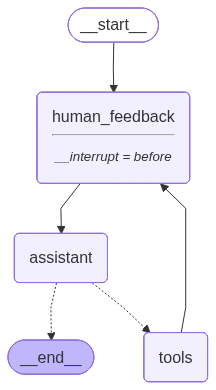

In [12]:
# 定义系统消息
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# 人工反馈节点：这是一个空操作节点，应该在此处中断
def human_feedback(state: MessagesState):
    """人工反馈节点：用于接收和处理用户输入

    Args:
        state: 包含消息列表的图状态

    Returns:
        无返回值，此节点主要用于中断点
    """
    pass

# 助手节点
def assistant(state: MessagesState):
    """助手节点：使用语言模型处理消息并可能调用工具

    Args:
        state: 包含消息列表的图状态

    Returns:
        包含AI响应的新状态更新
    """
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# 创建状态图构建器
builder = StateGraph(MessagesState)

# 定义节点：这些节点执行具体的工作
builder.add_node("assistant", assistant)  # AI助手节点
builder.add_node("tools", ToolNode(tools))  # 工具执行节点
builder.add_node("human_feedback", human_feedback)  # 人工反馈节点

# 定义边：这些边决定控制流程
builder.add_edge(START, "human_feedback")  # 从开始到人工反馈
builder.add_edge("human_feedback", "assistant")  # 从人工反馈到助手
builder.add_conditional_edges(
    "assistant",
    # 如果助手的最新消息是工具调用 -> tools_condition 路由到工具节点
    # 如果助手的最新消息不是工具调用 -> tools_condition 路由到结束
    tools_condition,
)
builder.add_edge("tools", "human_feedback")  # 从工具回到人工反馈

# 创建内存检查点保存器
memory = MemorySaver()

# 编译图，在human_feedback节点前设置中断点
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# 显示图的可视化结构
display(Image(graph.get_graph().draw_mermaid_png()))

我们将从用户那里获得反馈。

我们使用`.update_state`来用我们获得的人工响应更新图的状态，就像之前一样。

我们使用`as_node="human_feedback"`参数将此状态更新应用为指定的节点`human_feedback`。

In [13]:
# 定义初始输入
initial_input = {"messages": "Multiply 2 and 3"}

# 创建线程配置
thread = {"configurable": {"thread_id": "5"}}

# 运行图直到第一个中断点
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

# 获取用户输入
user_input = input("Tell me how you want to update the state: ")

# 我们现在更新状态，就像我们是human_feedback节点一样
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# 继续图执行
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
Tell me how you want to update the state: yes
================================ Human Message =================================

yes
================================== Ai Message ==================================
Tool Calls:
  multiply (call_e84l1bff3LoD4QbXbjOD8Kfv)
 Call ID: call_e84l1bff3LoD4QbXbjOD8Kfv
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [14]:
# 继续图执行，完成最终响应
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
